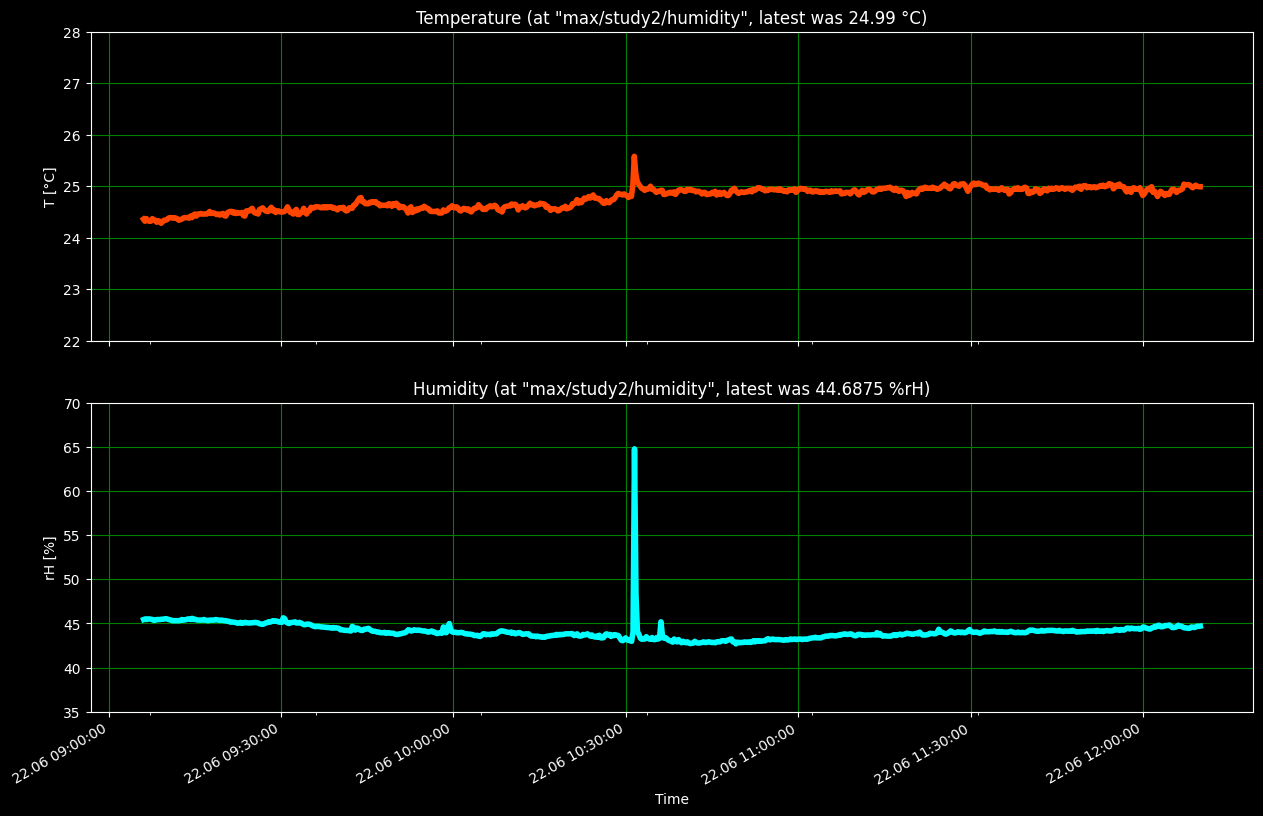

In [ ]:
#%matplotlib inline
%matplotlib inline 
import paho.mqtt.client as mqtt #import the client
import matplotlib
from IPython import display
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
import time
import datetime
import os

# Definitions
THE_TOPIC= "max/study2"
HOME_DIR=''
EXT= 'csv'
BROKER= '194.94.110.169'


FILENAME= os.path.join(HOME_DIR,THE_TOPIC.replace('/','_')+'X.'+EXT)


plt.ion()
plt.style.use('dark_background')
#data.to_csv('thdata_max_study.csv',index_col='Time')
import os.path

if os.path.isfile(FILENAME):
    data = pd.read_csv(FILENAME,index_col='Time')
    data.index=[datetime.datetime.strptime(str(x),'%Y-%m-%d %H:%M:%S.%f') for x in data.index]
else:
    data = pd.DataFrame(columns=['Temperature','Humidity'])
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=[15,10],sharex=True, dpi= 100)
ax1, ax2 = axes.ravel()
tempplot=None
humplot=None




def show_df():
    global data 
    display.display(data)
    




def append(dataframe, temperature=None,humidity=None):
    dataframe['intermediate']=dataframe.index
    dataframe=dataframe.append({'intermediate':datetime.datetime.now(),'Temperature':temperature,'Humidity':humidity},ignore_index=True)
    #dataframe.set_index('Time',inplace=True)
    dataframe.index=dataframe['intermediate']
    dataframe.index.rename('Time', inplace=True)
    del dataframe['intermediate']
    #print(dataframe.head())
    return(dataframe)


def process_message(client, userdata, message):
    global data
    global humplot
    global tempplot
    global THE_TOPIC
    t_topic= THE_TOPIC+"/temperature"
    h_topic= THE_TOPIC+"/humidity"
    value=float(message.payload)
    #print("isit",message.topic,'"'+t_topic+'"')
    #print("isit",message.topic,'"'+h_topic+'"')
    if message.topic not in [t_topic,h_topic]:
        print("received",message.topic,'"'+str(value)+'"')
    else:
        if message.topic == t_topic:
            data=append(data,value,None)
        elif message.topic == h_topic: 
            data=append(data,None,value)
        group='/'.join(message.topic.split('/'))
        data.to_csv(FILENAME)
        time.sleep(1)
        tlim=(float(int(data.Temperature[-240*6:].min()-2)//2*2),float(int(data.Temperature[-240*6:].max()+4)//2*2))

        hlim=(float(int(data.Humidity[-240*6:].min()-5)//5*5),float(int(data.Humidity[-240*6:].max()+10)//5*5))
        tempplot=data.Temperature[-240*6:].dropna().plot(ax=axes[0],title='Temperature (at "'+group+'", latest was '+str(data.Temperature.dropna()[-1])+' °C)',style='-',color=['orangered'],linewidth=4, ylim= tlim)#ylim=(-15,35),
        humplot=data.Humidity[-240*6:].dropna().plot(ax=axes[1],title='Humidity (at "'+group+'", latest was '+str(data.Humidity.dropna()[-1])+' %rH)',style='-',color=['aqua'],linewidth=4, ylim= hlim)#ylim=(0,100),
        tempplot.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%d.%m %H:%M:%S"))

        #tempplot.grid('off', which='minor', axis='x', color='grey' )
        tempplot.grid('on', which='major', axis='x', color='green'  )
        tempplot.grid('on', which='major', axis='y', color='green'  )
        #humplot.grid('off', which='minor', axis='x', color='grey' )
        humplot.grid('on', which='major', axis='x', color='green'  )
        humplot.grid('on', which='major', axis='y', color='green'  )
        tempplot.set_ylabel('T [°C]')
        humplot.set_ylabel('rH [%]')
        display.display(plt.gcf())
        display.clear_output(wait=True)

        if tempplot is not None:
            tempplot.clear()
        if humplot is not None:
            humplot.clear()


# Create client
client = mqtt.Client(client_id="subscriber-1")
print(client)
# Assign callback function
client.on_message = process_message

# Connect to broker
print(BROKER)
print(client.connect(BROKER))
print(THE_TOPIC+'/+')
# Subscriber to topic
client.subscribe(THE_TOPIC+'/+')
client.subscribe("max/study/humidity")


# Run loop
client.loop_forever()